- balanced the classifier dataset first

In [67]:
%reload_ext autoreload
%autoreload 2

from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns
from utils import *
from RingBuffer import RingBuffer
from sklearn import preprocessing
from sklearn import *
from scipy import signal 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import accuracy_score


In [2]:
agg_buffer = RingBuffer.readPickleStreamFile('../data/agg_buffer.pkl')

Total segment read: 305


(3355, 14)


(0.0, 2000.0)

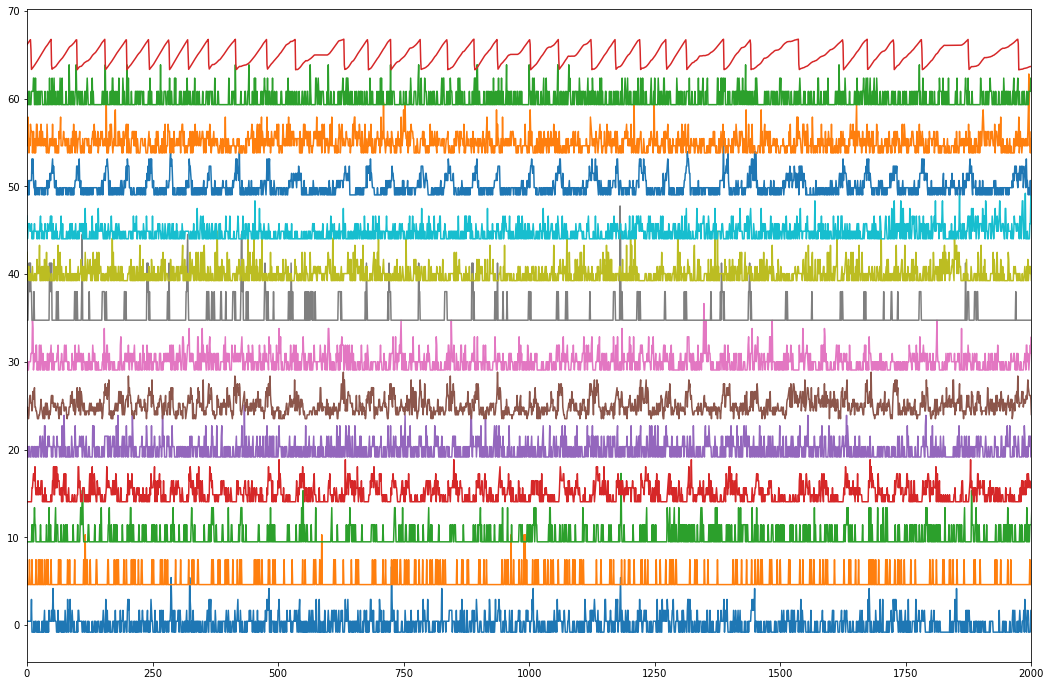

In [3]:
plt.figure(figsize=(18,12))
# signal2plot=np.hstack([norm_spiketrain,norm_pos_online])
scaler =preprocessing.StandardScaler()
print(agg_buffer.shape)
norm_agg_buffer = scaler.fit_transform(agg_buffer)

plot_multichannel(norm_agg_buffer.T,scale=5)
plt.xlim([0,2000])

### Decode

In [4]:
def makeSlidingWinFeature(x,win):
    feat = np.zeros((x.shape[0]-win+1,x.shape[1]*win))
    
    for i in range(x.shape[0]-win+1):
        feat[i,:] = x[i:i+win,:].ravel()
    return feat

y = np.ceil(np.random.rand(10,3)*10)
print(y)
x=makeSlidingWinFeature(y,4)
print(x)
print(x.shape)

[[ 1.  3.  1.]
 [ 5.  8.  5.]
 [ 8.  5.  3.]
 [ 8.  7.  9.]
 [ 4.  3.  7.]
 [ 3.  6. 10.]
 [ 2.  6.  5.]
 [10.  6.  4.]
 [ 7.  4.  9.]
 [ 4.  2.  7.]]
[[ 1.  3.  1.  5.  8.  5.  8.  5.  3.  8.  7.  9.]
 [ 5.  8.  5.  8.  5.  3.  8.  7.  9.  4.  3.  7.]
 [ 8.  5.  3.  8.  7.  9.  4.  3.  7.  3.  6. 10.]
 [ 8.  7.  9.  4.  3.  7.  3.  6. 10.  2.  6.  5.]
 [ 4.  3.  7.  3.  6. 10.  2.  6.  5. 10.  6.  4.]
 [ 3.  6. 10.  2.  6.  5. 10.  6.  4.  7.  4.  9.]
 [ 2.  6.  5. 10.  6.  4.  7.  4.  9.  4.  2.  7.]]
(7, 12)


0.5369866938038721 0.5370063630628368 0.44801786043133396


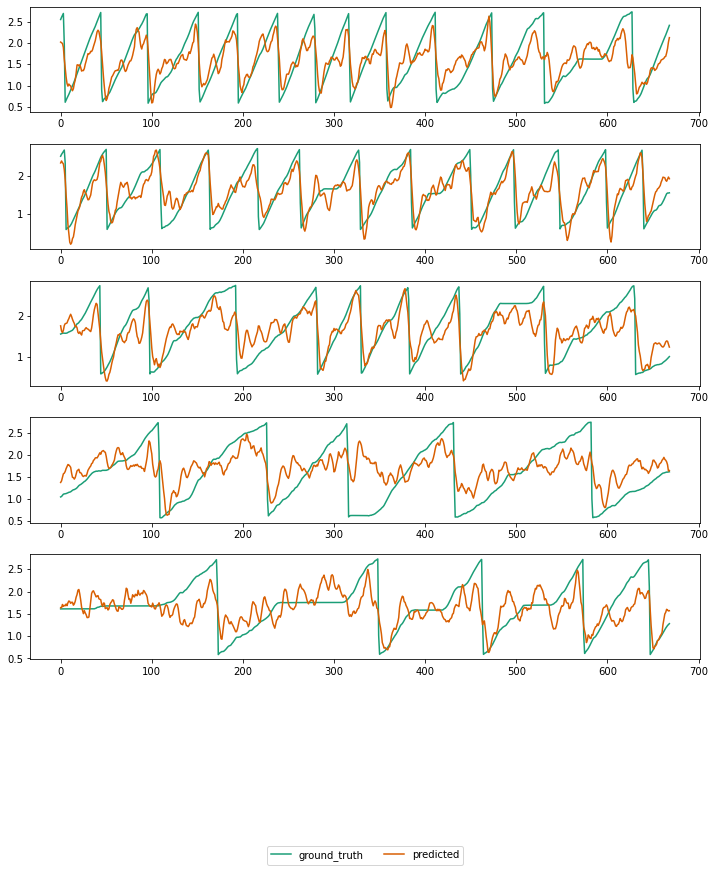

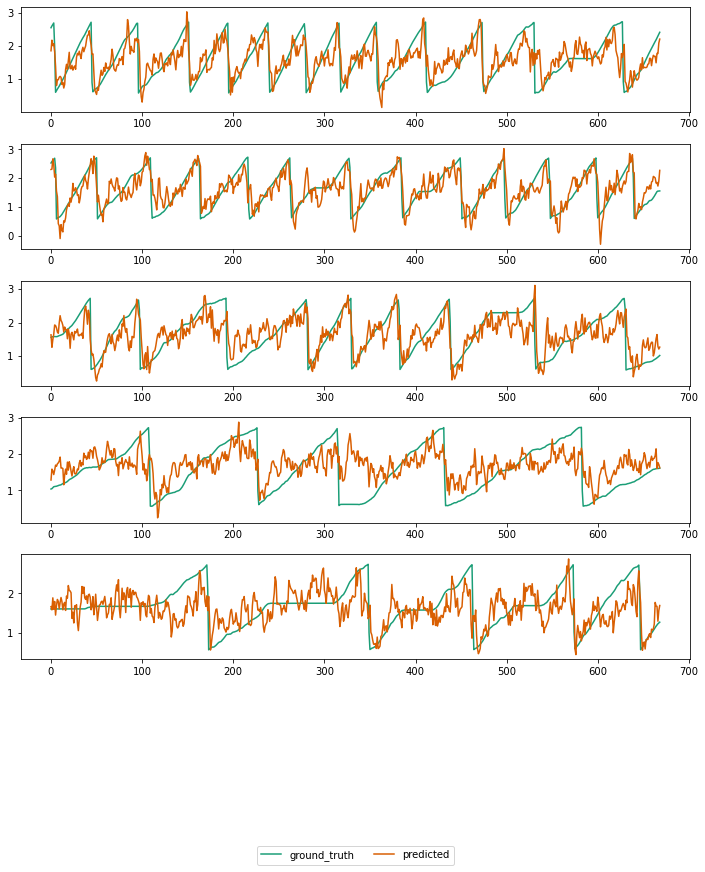

In [15]:

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train

# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
regressor.fit(poly_spiketrain,pos)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,pos.ravel(),cv=5)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(pos.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(pos.squeeze(),predicted_smooth.ravel())
varExplainRaw = metrics.explained_variance_score(pos.squeeze(),predicted.ravel())

print(r2,varExplain,varExplainRaw)
stripplot(pos,predicted_smooth,figsize=(12,12));
stripplot(pos,predicted,figsize=(12,12));


### Accuracy vs position

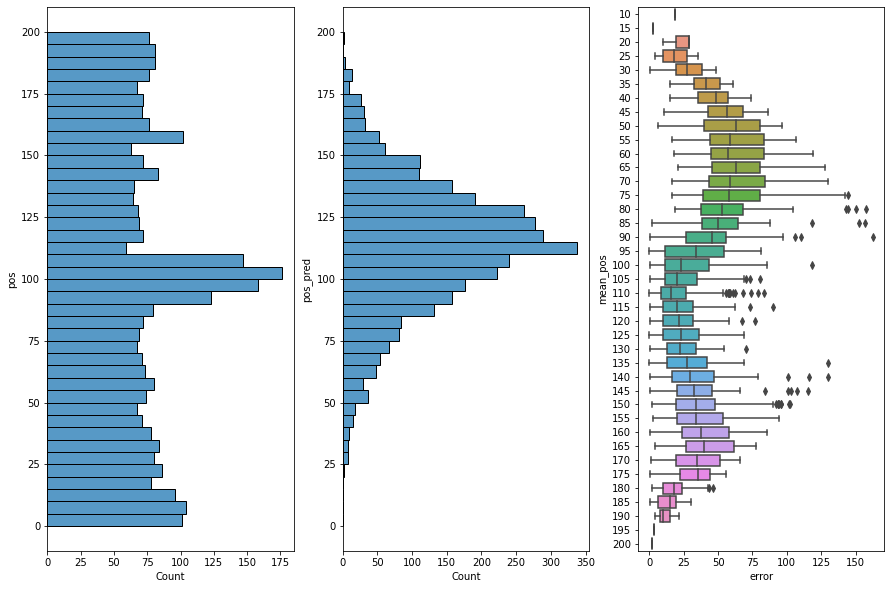

In [16]:
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
predicted_scaled = preprocessing.minmax_scale(predicted,(0,200))
bins = np.arange(0,205,5)
pos_binned = np.digitize(pos_scaled,bins,right=True)
error = np.abs(pos_scaled-predicted_scaled)
df = pd.DataFrame({'pos_binned':bins[pos_binned],'error':error})

mean_pos = (predicted_scaled+pos_scaled)/2
df['mean_pos'] = bins[np.digitize(mean_pos,bins)]

df['pos_pred'] = predicted_scaled
df['pos'] = pos_scaled

fig,ax = plt.subplots(1,3,figsize=(15,10))
sns.histplot(y='pos',binwidth=5,data=df,ax=ax[0])
sns.histplot(y='pos_pred',binwidth=5,data=df,ax=ax[1])
sns.boxplot(y='mean_pos',x='error',orient='h',data=df,ax=ax[2]);
# sns.swarmplot(y='mean_pos',x='error',orient='h',data=df,ax=ax[1],color='.25')

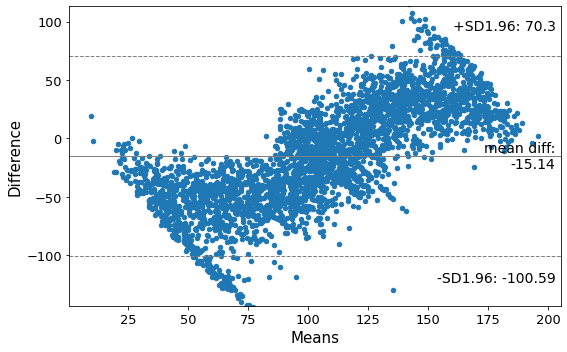

In [18]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(pos_scaled, predicted_scaled, ax = ax);

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


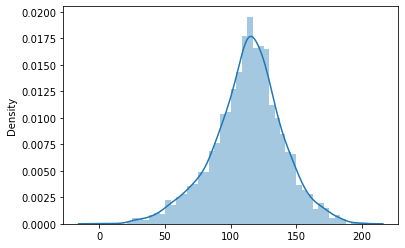

In [19]:
ax=sns.distplot(predicted_scaled)

### Classification approach

In [68]:
#use a classificaiton approach instead

spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

# bin the position into classes
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
bins = np.arange(0,205,10)
pos_binned = np.digitize(pos_scaled,bins,right=True)
pos_binned[pos_binned==0] = 1 # take care of samples outside bin range

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train

# resampler = RandomOverSampler(random_state=0) 
resampler = SMOTE()
val_results = balanced_cross_val_predict(classifier,resampler,poly_spiketrain,pos_binned,scorer=accuracy_score, return_prob=True)
print(val_results.score)

0.29752312742464937


Text(0.5, 69.0, 'Predicted label')

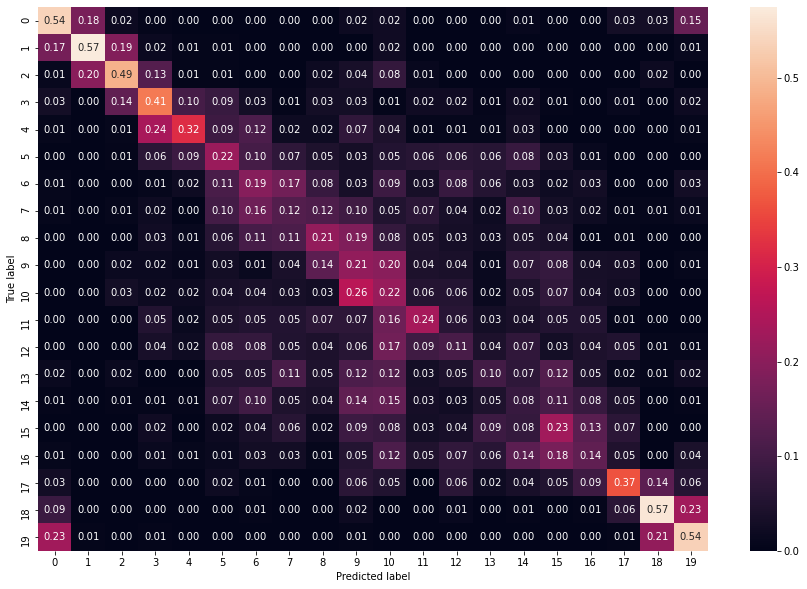

In [69]:
plt.figure(figsize=(15,10))
m = metrics.confusion_matrix(pos_binned,val_results.predicted,normalize='true') #row is true
ax=sns.heatmap(m,annot=True,fmt='.2f')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

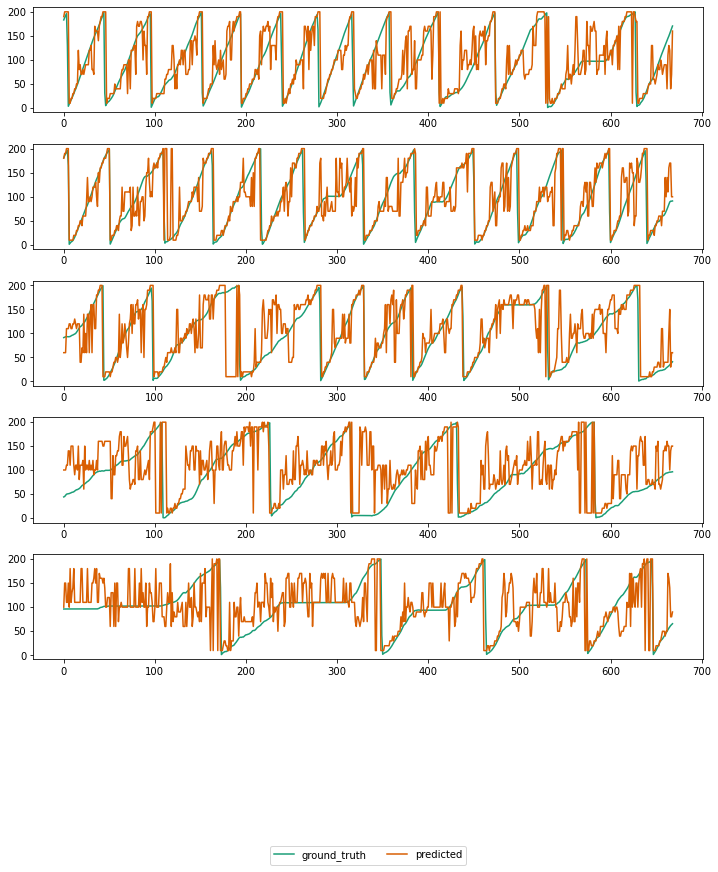

In [70]:
stripplot(pos_scaled,bins[predicted],figsize=(12,12));

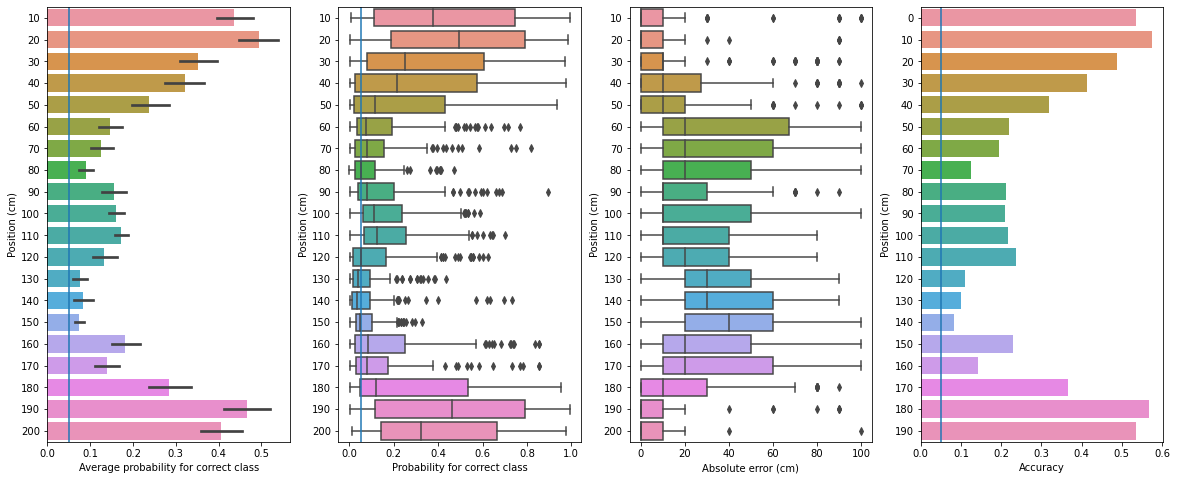

In [78]:
# classification probability vs location
predicted_prob = val_results.predict_prob
predicted_pos = val_results.predicted

true_class_prob = np.take_along_axis(predicted_prob,(pos_binned-1)[:,None],axis=1)
error = np.abs((predicted_pos-pos_binned))*10
error[error>100] = 200 - error[error>100]
#since 200 and 0 are next to each other, so we change the position to an angle
# plot the firing rate in a circle

df_class = pd.DataFrame({'prob':true_class_prob.ravel(), 'pos':(pos_binned)*10, 'error': error})

fig,ax = plt.subplots(1,4,figsize=(20,8))
axIdx = 0
sns.barplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Average probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])

# fig,ax = plt.subplots(1,1,figsize=(10,8))
axIdx += 1
sns.boxplot(x='prob',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Probability for correct class')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])

axIdx += 1
sns.boxplot(x='error',y='pos',orient='h',data=df_class, ax = ax[axIdx])
ax[axIdx].set_xlabel('Absolute error (cm)')
ax[axIdx].set_ylabel('Position (cm)');



# accuracy for each position
axIdx +=1
accuracy = []
for i in range(predicted_prob.shape[1]):
    idx = (pos_binned==i+1) #pos_binned is from 1 to 20
    accuracy.append(np.mean(pos_binned[idx] == predicted_pos[idx]))

sns.barplot(y=np.arange(0,200,10),x=accuracy,orient='h',ax=ax[axIdx])
ax[axIdx].set_xlabel('Accuracy')
ax[axIdx].set_ylabel('Position (cm)');
ax[axIdx].axvline(1/predicted_prob.shape[1])


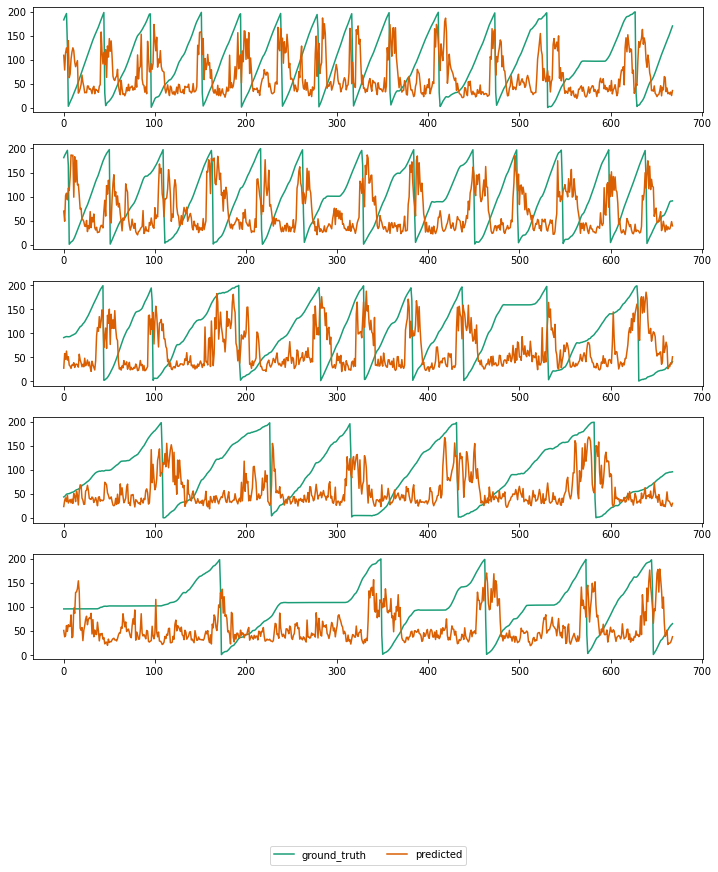

In [11]:
stripplot(pos_scaled,np.max(predicted_prob,axis=1)*200,figsize=(12,12));
